# Amazon fine food review data analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset contain Amazon food review from Oct 1999 - Oct 2012 for nearly 75k products.

### This dataset contains following columns :
  1. Id
  2. ProductId - unique identifier for the product
  3. UserId - uniqiue identifier for the user
  4. ProfileName
  5. HelpfulnessNumerator - number of users who found the review helpful
  6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
  7. Score - rating between 1 and 5
  8. Time - timestamp for the review
  9. Summary - brief summary of the review
  10. Text - text of the review


### Objective :
  Based on given food reviews classify them in two classes i.e. positive and negative.
  
  To achieve above objective we will first try to visualize the data using two columns Score and Text and perform following operations on it.
  1. Data cleaning and transformation
      - Remove duplicate data 
      - Transform Score column value 1-2 to ""negative" and 4-5 to "positive".  
      - Remove html tags, non-English  words, words smaller than 2 alphabets, stop words and special symbols.
      - convert words to lower case and apply stemming,  lemmatization.
      - select 1K data points for each positive and negative class.
  2. vectorize Text column using 
      * Bag Of Word
      * tf-idf
      * Average W2V
      * tf-idf weighted W2V
  3. Visualize review vectors using tsne for different perplexity value.






# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 



In [1]:
import sqlite3
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
#read data from gdrive into pandas dataframe
#conn = sqlite3.connect('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/database.sqlite')
conn = sqlite3.connect('amazon-fine-food-reviews/database.sqlite')
all_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)

all_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
#convert all Scores having value 1 or 2 to negative and 4 or 5 to positive.

set_val = {1:"negative",2:"negative",4:"positive",5:"positive"}
all_data = all_data.replace({'Score':set_val})
all_data['Score'] = all_data['Score'].astype('category')
all_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
#sort data based on ProductId column
sorted_data=all_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#reamoving duplicate rows
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [6]:
# Select only those columns whose HelpfulnessDenominator value is greater than HelpfulnessNumerator

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
#download all english stop words using nltk
import nltk
#nltk.download('stopwords')
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/nanduramchavan_01/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
import os
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from collections import Counter


In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stop= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
#functions to remove special charachers and html tags

#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [13]:
# removing html tags, punctuation, non english words nad top words

if not os.path.isfile('amazon-fine-food-reviews/final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    word_count=[]
    noun_count=[]
    adj_count=[]
    verb_count=[]
    adverb_count=[]
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        sent=cleanhtml(sent) # remove HTMl tags
        sent = re.sub(r"http\S+", "", sent)
        sent = BeautifulSoup(sent, 'lxml').get_text()
        sent = decontracted(sent)
        sent = re.sub("\S*\d\S*", "", sent).strip()
        sent = re.sub('[^A-Za-z]+', ' ', sent)
        #create new features
        words = []
        words = cleanpunc(sent).split()
        word_count.append(len(words))
        #count pos tags
        pos_tags = nltk.pos_tag(words, tagset='universal')
        count = Counter(elem[1] for elem in pos_tags)
        noun_count.append(count["NOUN"])
        adj_count.append(count["ADJ"])
        verb_count.append(count["VERB"])
        adverb_count.append(count["ADV"])
        for cleaned_words in words:
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(wordnet_lemmatizer.lemmatize(cleaned_words.lower(), pos="v")).encode('utf8')
                    #s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words

        final_string.append(str1)
        i+=1

    #Store data into .sqlite file 
    
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    final['TextWordCount'] = word_count
    final['NounCount'] = noun_count
    final['AdjCount'] = adj_count
    final['VerbCount'] = verb_count
    final['AdverbCount'] = adverb_count
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('amazon-fine-food-reviews/final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('amazon-fine-food-reviews/positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('amazon-fine-food-reviews/negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 364171/364171 [42:18<00:00, 143.43it/s] 


In [3]:
# read cleamed data from previously stored sqlite file

#conn = sqlite3.connect('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/final.sqlite')
conn = sqlite3.connect('amazon-fine-food-reviews/final.sqlite')
  
clean_data = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
clean_data.columns

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText', 'TextWordCount', 'NounCount',
       'AdjCount', 'VerbCount', 'AdverbCount'],
      dtype='object')

In [4]:
# sort data by time
type(clean_data)
clean_data = clean_data.sort_values(by='Time', axis=0,ascending=True)
clean_data.tail()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,TextWordCount,NounCount,AdjCount,VerbCount,AdverbCount
139298,511105,552637,B0012EYELE,AWQOTHBNJBSVB,"Gregory E. Grant ""GG""",0,0,negative,1351209600,Couldn't tell you how it tasted,"The bottle was not sealed, and when I opened t...",bottle not seal open cover black crusty stuff ...,24,4,3,6,4
333542,282454,306008,B0058CGLH6,A3QRR5YN6ALFPG,james a riche,0,0,negative,1351209600,If you like Campbells Pepper pot soup then don...,"Not at all like pepper pot soup, it is just a ...",not like pepper pot soup crab soup little flav...,27,9,2,5,3
139690,311138,336872,B0012KB4U2,AGQBI6601XH2R,DaniC,0,0,positive,1351209600,Both cats love these!,They only like this brand and flavor of treat....,like brand flavor treat not soft version one c...,51,11,2,9,4
213087,524273,566798,B001PQTYN2,A3OTHWG8LLCLMU,"PACKERS FAN ""Gordon Boone""",1,1,positive,1351209600,Great,"If you like a great , hot, sauce then buy this...",like great hot sauce buy spicy heat not like n...,24,3,2,6,4
57313,355171,384161,B000EVWQZW,A2PCNXBSKCABG5,Whit,0,0,positive,1351209600,Versatile Mix,This mix makes a good bread or can also be use...,mix make good bread also use make pop overs ne...,40,12,2,9,2


In [5]:
# get 100k clean data points 
final_data = clean_data[:100000].copy()
final_data.shape

(100000, 17)

In [6]:
final_data['Score'].value_counts()

positive    87729
negative    12271
Name: Score, dtype: int64

In [9]:
x = final_data["CleanedText"][:8000]
y = final_data["Score"]


In [7]:
from  sklearn.model_selection import train_test_split
import pickle

In [8]:
X_train = final_data["CleanedText"][:60000]
y_train = final_data["Score"][:60000]
X_val = final_data["CleanedText"][60000:80000]
y_val = final_data["Score"][60000:80000]
X_test = final_data["CleanedText"][80000:]
y_test = final_data["Score"][80000:]

In [9]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print (X_val.shape, y_val.shape)

(60000,) (60000,)
(20000,) (20000,)
(20000,) (20000,)


In [15]:
with open("amazon-fine-food-reviews/X_train.pkl","wb") as file:
  pickle.dump(X_train, file)
  
with open("amazon-fine-food-reviews/X_test.pkl","wb") as file:
  pickle.dump(X_test, file)

with open("amazon-fine-food-reviews/X_val.pkl","wb") as file:
  pickle.dump(X_val, file)
  
with open("amazon-fine-food-reviews/y_train.pkl","wb") as file:
  pickle.dump(y_train, file)

with open("amazon-fine-food-reviews/y_test.pkl","wb") as file:
  pickle.dump(y_test, file)

with open("amazon-fine-food-reviews/y_val.pkl","wb") as file:
  pickle.dump(y_val, file)


# [4] Featurization

## [4.1] BAG OF WORDS

In [16]:
from sklearn.feature_extraction.text import CountVectorizer


In [17]:
cv = CountVectorizer()
review_BOW = cv.fit_transform(X_train.values)
print("Shape of train BOW matrix : ",review_BOW.shape)
val_review_BOW = cv.transform(X_val.values)
print("Shape of test BOW matrix : ",val_review_BOW.shape)
test_review_BOW = cv.transform(X_test.values)
print("Shape of test BOW matrix : ",test_review_BOW.shape)

Shape of train BOW matrix :  (60000, 36535)
Shape of test BOW matrix :  (20000, 36535)
Shape of test BOW matrix :  (20000, 36535)


In [18]:
with open("amazon-fine-food-reviews/bow/BOW_x_train.pkl","wb") as file:
  pickle.dump(review_BOW, file)
  
with open("amazon-fine-food-reviews/bow/BOW_x_val.pkl","wb") as file:
  pickle.dump(val_review_BOW, file)
  
with open("amazon-fine-food-reviews/bow/BOW_x_test.pkl","wb") as file:
  pickle.dump(test_review_BOW, file)


## [4.2] TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tf_idf_model = TfidfVectorizer(ngram_range=(1,2))
train_review_tf_idf = tf_idf_model.fit_transform(X_train.values)
val_review_tf_idf = tf_idf_model.transform(X_val.values)
test_review_tf_idf = tf_idf_model.transform(X_test.values)

In [21]:
with open("amazon-fine-food-reviews/tfidf/tfidf_x_train.pkl","wb") as file:
  pickle.dump(train_review_tf_idf, file)

with open("amazon-fine-food-reviews/tfidf/tfidf_x_val.pkl","wb") as file:
  pickle.dump(val_review_tf_idf, file)
  
with open("amazon-fine-food-reviews/tfidf/tfidf_x_test.pkl","wb") as file:
  pickle.dump(test_review_tf_idf, file)

## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

### [4.3.1.1] Avg W2v

In [23]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
from tqdm import tqdm

In [24]:
train_list_of_sent=[]
val_list_of_sent=[]
test_list_of_sent=[]
for sent in X_train.values:   #extract train and test sentences to apply created w2v model
    train_list_of_sent.append(sent.split())
for sent in X_val.values:
    val_list_of_sent.append(sent.split())
for sent in X_test.values:
    test_list_of_sent.append(sent.split())


In [25]:
#train data avg w2v
w2v_model=Word2Vec(train_list_of_sent,min_count=5,size=50, workers=4) #min_count-word should have min this many count to be included in w2v, size- n X 50
w2v_words = list(w2v_model.wv.vocab)

In [26]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(train_list_of_sent): # for each tain review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print("\n",len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 60000/60000 [02:08<00:00, 465.80it/s]


 60000
50


In [27]:
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_train.pkl","wb") as file:
  pickle.dump(sent_vectors, file)

In [28]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(test_list_of_sent): # for each test  review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print("\n",len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 20000/20000 [00:46<00:00, 430.10it/s]


 20000
50


In [29]:
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_test.pkl","wb") as file:
  pickle.dump(sent_vectors, file)

In [30]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(val_list_of_sent): # for each test  review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print("\n",len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 20000/20000 [00:48<00:00, 416.36it/s]


 20000
50


In [31]:
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_val.pkl","wb") as file:
  pickle.dump(sent_vectors, file)

### [4.3.1.2] TFIDF weighted W2v

In [32]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values) #create tfidf matrix on all data
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
def tf_idf_w2v(sen_list,filename):
  # TF-IDF weighted Word2Vec
  tfidf_feat = model.get_feature_names() # tfidf words/col-names
  # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

  tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
  row=0;

  for sent in tqdm(sen_list): # for each review/sentence 
      sent_vec = np.zeros(50) # as word vectors are of zero length
      weight_sum =0; # num of words with a valid vector in the sentence/review
      for word in sent: # for each word in a review/sentence
          if word in w2v_words:
              vec = w2v_model.wv[word]
              tf_idf = dictionary[word]*(sent.count(word)/len(sent))
              sent_vec += (vec * tf_idf)
              weight_sum += tf_idf
      if weight_sum != 0:
          sent_vec /= weight_sum
      tfidf_sent_vectors.append(sent_vec)
      row += 1

  with open("amazon-fine-food-reviews/tfidf_w2v/"+filename,"wb") as file:
    pickle.dump(tfidf_sent_vectors, file)

In [34]:
sent_list = [train_list_of_sent,test_list_of_sent,val_list_of_sent]
filenames = ["tfidf_w2v_x_train.pkl","tfidf_w2v_x_test.pkl","tfidf_w2v_x_val.pkl"]
for idx in range(len(sent_list)):
  tf_idf_w2v(sent_list[idx],filenames[idx])

100%|██████████| 20000/20000 [00:55<00:00, 358.64it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
import sqlite3
import pandas as pd

In [9]:
# read BOW vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/bow/BOW_x_train.pkl","rb") as file:
  BOW_x_train = pickle.load(file) 
  
with open("amazon-fine-food-reviews/bow/BOW_x_val.pkl","rb") as file:
  BOW_x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/bow/BOW_x_test.pkl","rb") as file:
  BOW_x_test = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  BOW_y_train = pickle.load(file)
  BOW_y_train = [1 if x=='positive' else 0 for x in BOW_y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  BOW_y_test = pickle.load(file)
  BOW_y_test = [1 if x=='positive' else 0 for x in BOW_y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  BOW_y_val = pickle.load(file)  
  BOW_y_val = [1 if x=='positive' else 0 for x in BOW_y_val]

In [10]:
# creating odd list of K for KNN
myList = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    knn.fit(BOW_x_train,BOW_y_train)
    
    #predict probabilities for train and validation    
    train_pred_prob = knn.predict_proba(BOW_x_train)[:,1]
    val_pred_prob = knn.predict_proba(BOW_x_val)[:,1]
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(BOW_y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(BOW_y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))   

100%|██████████| 20/20 [1:34:28<00:00, 287.28s/it]


In [ ]:
# finding best K with cross validation
print("K with maximum score in Kfold validation : {0}, max validation AUC :{1}".format(neighbors[val_auc.index(max(val_auc))],max(val_auc)))


## [5.1.1.1] AUC graph, ROC and confusion matrix for data with new features

In [4]:
# read cleamed data from previously stored sqlite file

#conn = sqlite3.connect('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/final.sqlite')
conn = sqlite3.connect('amazon-fine-food-reviews/sorted_final.sqlite')
all_data = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
all_data.columns

Index(['level_0', 'index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText', 'TextWordCount', 'NounCount',
       'AdjCount', 'VerbCount', 'AdverbCount'],
      dtype='object')

In [5]:
data = all_data.iloc[:,13:].copy()
data.head(5)

,TextWordCount,NounCount,AdjCount,VerbCount,AdverbCount
0,76,17,9,18,3
1,75,18,3,15,5
2,28,5,2,9,1
3,37,12,4,6,3
4,45,10,9,9,1


In [6]:
from scipy.sparse import coo_matrix, hstack
from scipy.sparse.csr import csr_matrix


data_array = data.as_matrix()
data_array = csr_matrix(data_array)
train = data_array[0:60000]
val = data_array[60000:80000]
test = data_array[80000:]

/home/nanduramchavan_01/anaconda3/envs/aaic/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [12]:
#concatenate vectorized words and numerical features
BOW_x_train = hstack([BOW_x_train,train])
BOW_x_val = hstack([BOW_x_val,val])
BOW_x_test = hstack([BOW_x_test,test])

#after this run above cross validation step

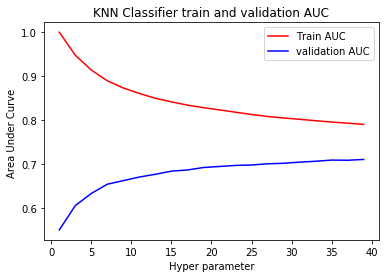

In [17]:
# AUC graph for data with extra features
plt.figure()
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

In [18]:
train_auc = []
myList = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
for k in neighbors:
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    #val_auc.append(auc(val_fpr[k], val_tpr[k]))

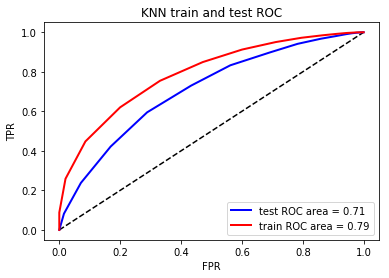

In [19]:
k = neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs=-1)
knn.fit(BOW_x_train,BOW_y_train)
test_pred_prob = knn.predict_proba(BOW_x_test)[:,1]

# test AUC
test_fpr, test_tpr, _ = roc_curve(BOW_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [22]:
test_pred = knn.predict(BOW_x_test)
conf_matrix = confusion_matrix(BOW_y_test, test_pred)
report = classification_report(BOW_y_test, test_pred)
print("confusion matrix\n",conf_matrix)
print("report\n",report)
 

confusion matrix
 [[    1  2677]
 [    0 17322]]
report
               precision    recall  f1-score   support

           0       1.00      0.00      0.00      2678
           1       0.87      1.00      0.93     17322

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.93      0.50      0.46     20000
weighted avg       0.88      0.87      0.80     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

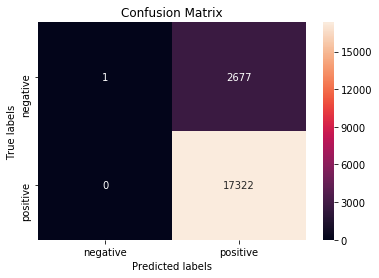

In [6]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

## [5.1.1.2] AUC graph, ROC and confusion matrix for original data

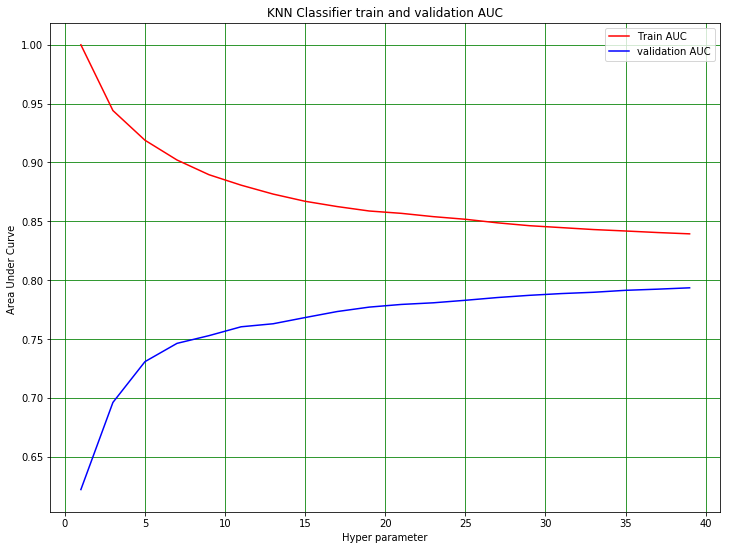

In [11]:
# AUC graph for data with extra features
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show() 

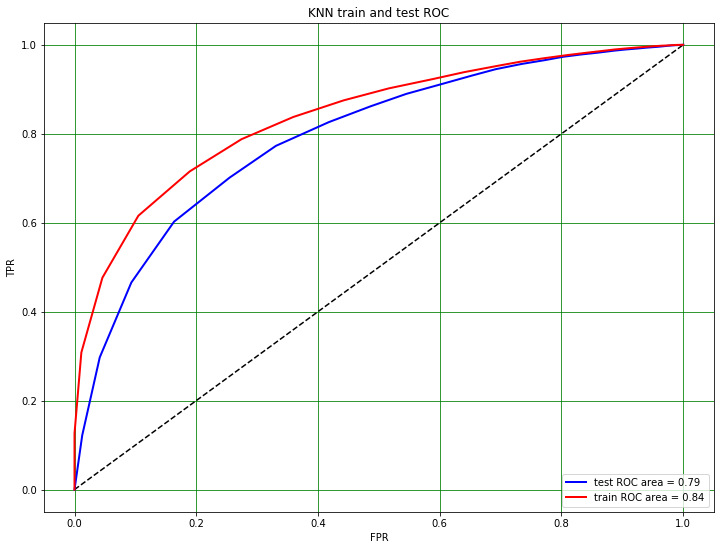

In [13]:
k = neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute')
knn.fit(BOW_x_train,BOW_y_train)
test_pred_prob = knn.predict_proba(BOW_x_test)[:,1]

# test AUC
test_fpr, test_tpr, _ = roc_curve(BOW_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [14]:
test_pred = knn.predict(BOW_x_test)
conf_matrix = confusion_matrix(BOW_y_test, test_pred)
report = classification_report(BOW_y_test, test_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.58      0.08      0.13      2678
           1       0.87      0.99      0.93     17322

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.73      0.53      0.53     20000
weighted avg       0.83      0.87      0.82     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

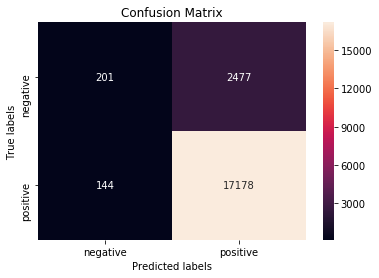

In [9]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [1]:
# read TFIDF vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/tfidf/tfidf_x_train.pkl","rb") as file:
  TFIDF_x_train = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf/tfidf_x_val.pkl","rb") as file:
  TFIDF_x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf/tfidf_x_test.pkl","rb") as file:
  TFIDF_x_test = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  TFIDF_y_train = pickle.load(file)
  TFIDF_y_train = [1 if x=='positive' else 0 for x in TFIDF_y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  TFIDF_y_test = pickle.load(file)
  TFIDF_y_test = [1 if x=='positive' else 0 for x in TFIDF_y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  TFIDF_y_val = pickle.load(file)  
  TFIDF_y_val = [1 if x=='positive' else 0 for x in TFIDF_y_val]

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
# creating odd list of K for KNN
myList = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute', n_jobs=6)
    #scores = cross_val_score(knn, TFIDF_x_train, TFIDF_y_train, cv=5, scoring='accuracy')
    #cv_scores.append(scores.mean())
    knn.fit(TFIDF_x_train,TFIDF_y_train)
    
    #predict probabilities for train and validation
    train_pred_prob = knn.predict_proba(TFIDF_x_train)[:,1]
    val_pred_prob = knn.predict_proba(TFIDF_x_val)[:,1]
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(TFIDF_y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(TFIDF_y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))   

100%|██████████| 20/20 [1:45:50<00:00, 323.70s/it]


### AUC graph, ROC and confusion matrix for data with new features

In [8]:
#concatenate vectorized words and numerical features
TFIDF_x_train = hstack([TFIDF_x_train,train])
TFIDF_x_val = hstack([TFIDF_x_val,val])
TFIDF_x_test = hstack([TFIDF_x_test,test])

K with maximum score on validation data :  39


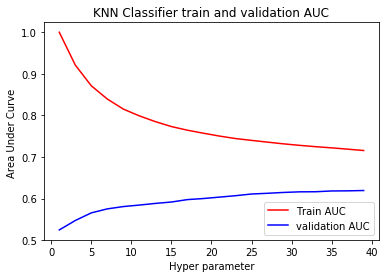

In [12]:
# finding best K with cross validation
print("K with maximum score on validation data : ",neighbors[val_auc.index(max(val_auc))])
plt.figure()
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="lower right")
plt.show() 

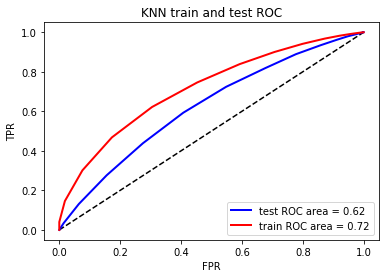

In [13]:
k = neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs=-1)
knn.fit(TFIDF_x_train,TFIDF_y_train)
test_pred_prob = knn.predict_proba(TFIDF_x_test)[:,1]
# test AUC
test_fpr, test_tpr, _ = roc_curve(TFIDF_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [14]:
test_pred = knn.predict(TFIDF_x_test)
conf_matrix = confusion_matrix(TFIDF_y_test, test_pred)
report = classification_report(TFIDF_y_test, test_pred)
print("confusion matrix\n",conf_matrix)
print("report\n",report)
 

confusion matrix
 [[    0  2678]
 [    0 17322]]
report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2678
           1       0.87      1.00      0.93     17322

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.43      0.50      0.46     20000
weighted avg       0.75      0.87      0.80     20000



/home/nanduramchavan_01/anaconda3/envs/aaic/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

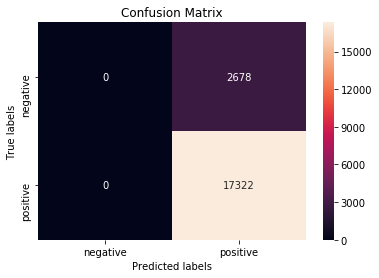

In [10]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### AUC graph, ROC and confusion matrix for original data

K with maximum score on validation data :  39


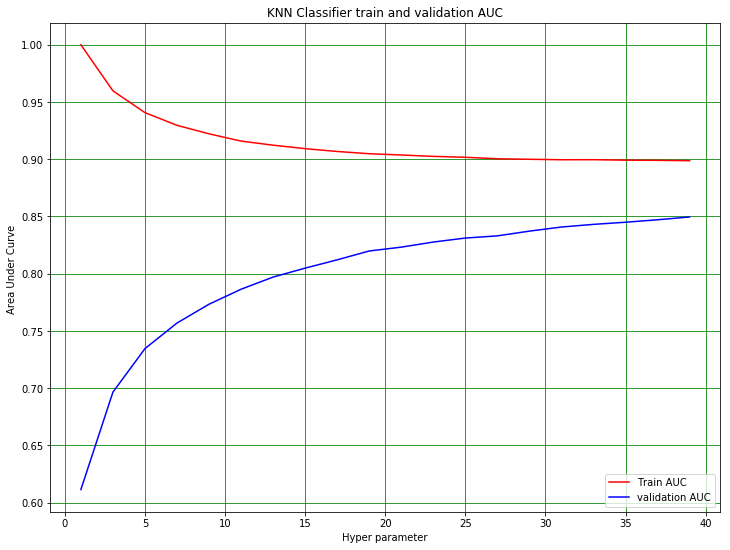

In [4]:
# finding best K with cross validation
print("K with maximum score on validation data : ",neighbors[val_auc.index(max(val_auc))])
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="lower right")
plt.show() 

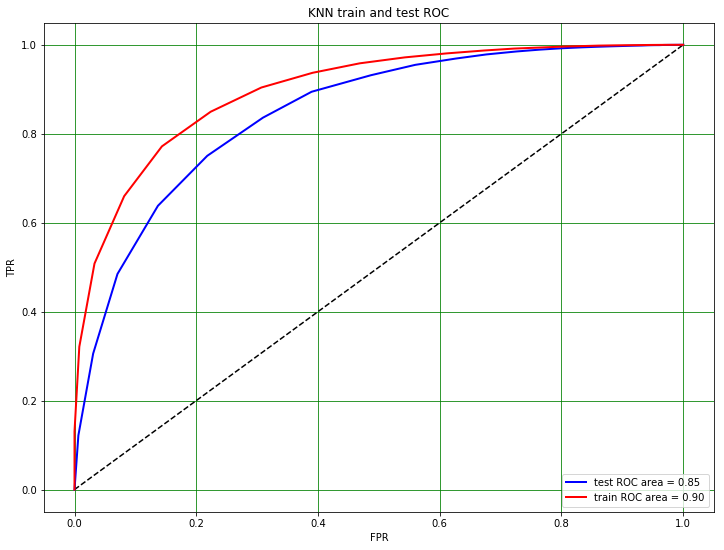

In [5]:
k = neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs=6)
knn.fit(TFIDF_x_train,TFIDF_y_train)
test_pred_prob = knn.predict_proba(TFIDF_x_test)[:,1]
# test AUC
test_fpr, test_tpr, _ = roc_curve(TFIDF_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [8]:
test_pred = knn.predict(TFIDF_x_test)
conf_matrix = confusion_matrix(TFIDF_y_test, test_pred)
report = classification_report(TFIDF_y_test, test_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.87      0.07      0.13      2678
           1       0.87      1.00      0.93     17322

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.87      0.53      0.53     20000
weighted avg       0.87      0.87      0.82     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

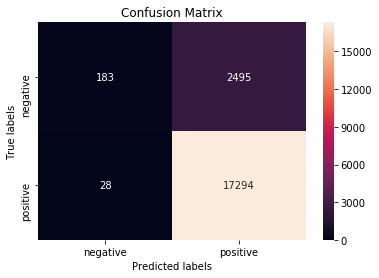

In [11]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [10]:
# read BOW vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_train.pkl","rb") as file:
  avg_w2v_x_train = pickle.load(file)

with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_val.pkl","rb") as file:
  avg_w2v_x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_test.pkl","rb") as file:
  avg_w2v_x_test = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  avg_w2v_y_train = pickle.load(file)
  avg_w2v_y_train = [1 if x=='positive' else 0 for x in avg_w2v_y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  avg_w2v_y_test = pickle.load(file)
  avg_w2v_y_test = [1 if x=='positive' else 0 for x in avg_w2v_y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  avg_w2v_y_val = pickle.load(file)  
  avg_w2v_y_val = [1 if x=='positive' else 0 for x in avg_w2v_y_val]

In [11]:
# creating odd list of K for KNN
myList = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
import time
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute',n_jobs = 6)
    knn.fit(avg_w2v_x_train,avg_w2v_y_train)
    
    #predict probabilities for train and validation
    train_pred_prob = knn.predict_proba(avg_w2v_x_train)[:,1]
    val_pred_prob = knn.predict_proba(avg_w2v_x_val)[:,1]
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(avg_w2v_y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(avg_w2v_y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))   

100%|██████████| 20/20 [1:42:26<00:00, 304.78s/it]


### AUC graph, ROC and confusion matrix for data with new features

In [8]:
#concatenate vectorized words and numerical features
avg_w2v_x_train = hstack([avg_w2v_x_train,train])
avg_w2v_x_val = hstack([avg_w2v_x_val,val])
avg_w2v_x_test = hstack([avg_w2v_x_test,test])

K with maximum score on validation data :  39


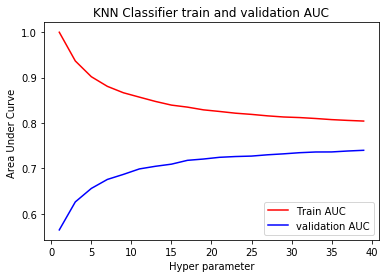

In [10]:
# finding best K with cross validation
print("K with maximum score on validation data : ",neighbors[val_auc.index(max(val_auc))])
plt.figure()
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="lower right")
plt.show() 

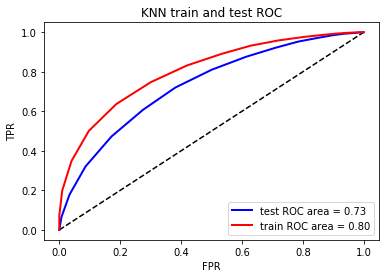

In [11]:
k = neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs=-1)
knn.fit(avg_w2v_x_train,avg_w2v_y_train)
test_pred_prob = knn.predict_proba(avg_w2v_x_test)[:,1]
# test AUC
test_fpr, test_tpr, _ = roc_curve(avg_w2v_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [12]:
test_pred = knn.predict(avg_w2v_x_test)
conf_matrix = confusion_matrix(avg_w2v_y_test, test_pred)
report = classification_report(avg_w2v_y_test, test_pred)
print("confusion matrix\n",conf_matrix)
print("report\n",report)
 

confusion matrix
 [[    4  2674]
 [    1 17321]]
report
               precision    recall  f1-score   support

           0       0.80      0.00      0.00      2678
           1       0.87      1.00      0.93     17322

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.83      0.50      0.47     20000
weighted avg       0.86      0.87      0.80     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

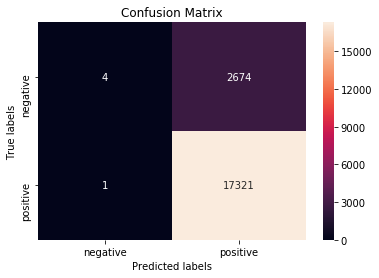

In [12]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### AUC graph, ROC and confusion matrix for original data

K with maximum score on validation data :  39


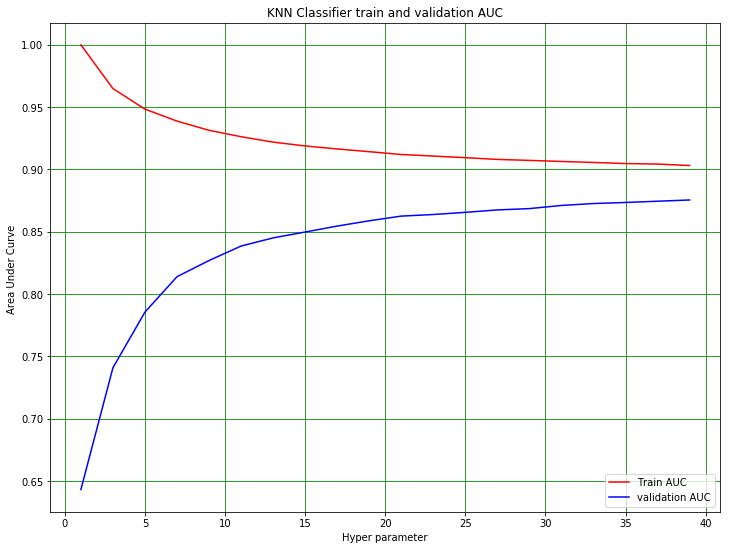

In [12]:
# finding best K with cross validation
print("K with maximum score on validation data : ",neighbors[val_auc.index(max(val_auc))])
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="lower right")
plt.show() 

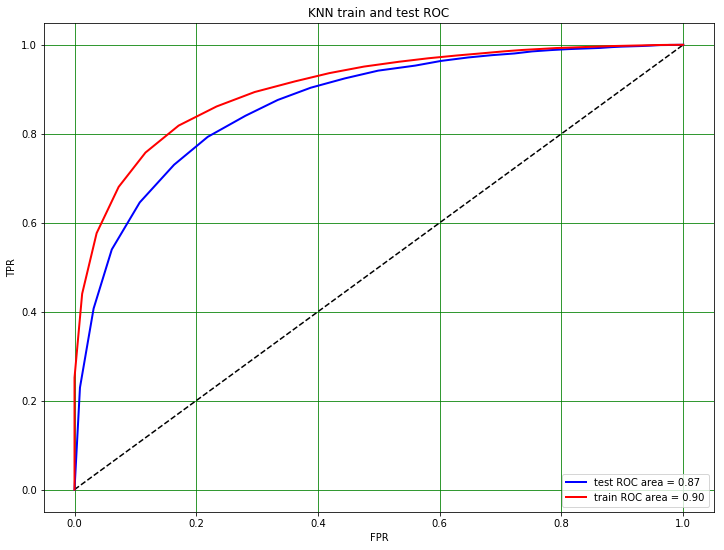

In [13]:
k = neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs=6)
knn.fit(avg_w2v_x_train,avg_w2v_y_train)
test_pred_prob = knn.predict_proba(avg_w2v_x_test)[:,1]
# test AUC
test_fpr, test_tpr, _ = roc_curve(avg_w2v_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [14]:
test_pred = knn.predict(avg_w2v_x_test)
conf_matrix = confusion_matrix(avg_w2v_y_test, test_pred)
report = classification_report(avg_w2v_y_test, test_pred)
print("report\n",report)
 

report
               precision    recall  f1-score   support

           0       0.75      0.16      0.26      2678
           1       0.88      0.99      0.93     17322

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.82      0.58      0.60     20000
weighted avg       0.87      0.88      0.85     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

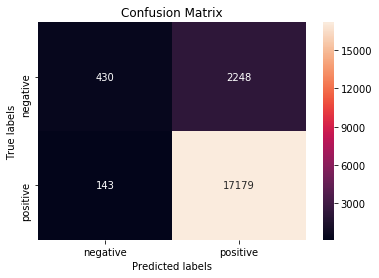

In [13]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [17]:
# read BOW vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_train.pkl","rb") as file:
  tfidf_w2v_x_train = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_val.pkl","rb") as file:
  tfidf_w2v_x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_test.pkl","rb") as file:
  tfidf_w2v_x_test = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  tfidf_w2v_y_train = pickle.load(file)
  tfidf_w2v_y_train = [1 if x=='positive' else 0 for x in tfidf_w2v_y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  tfidf_w2v_y_test = pickle.load(file)
  tfidf_w2v_y_test = [1 if x=='positive' else 0 for x in tfidf_w2v_y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  tfidf_w2v_y_val = pickle.load(file)  
  tfidf_w2v_y_val = [1 if x=='positive' else 0 for x in tfidf_w2v_y_val]

In [18]:
# creating odd list of K for KNN
myList = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute', n_jobs=6)
    knn.fit(tfidf_w2v_x_train,tfidf_w2v_y_train)
    
    #predict probabilities for train and validation
    train_pred_prob = knn.predict_proba(tfidf_w2v_x_train)[:,1]
    val_pred_prob = knn.predict_proba(tfidf_w2v_x_val)[:,1]
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(tfidf_w2v_y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(tfidf_w2v_y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))   

100%|██████████| 20/20 [1:45:32<00:00, 324.14s/it]


### AUC graph, ROC and confusion matrix for data with new features

In [ ]:
#concatenate vectorized words and numerical features
tfidf_w2v_x_train = hstack([tfidf_w2v_x_train,train])
tfidf_w2v_x_val = hstack([tfidf_w2v_x_val,val])
tfidf_w2v_x_test = hstack([tfidf_w2v_x_test,test])

K with maximum score on validation data :  39


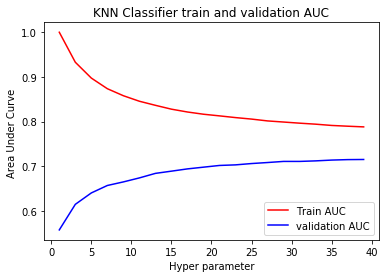

In [10]:
# finding best K with cross validation
print("K with maximum score on validation data : ",neighbors[val_auc.index(max(val_auc))])
plt.figure()
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="lower right")
plt.show() 

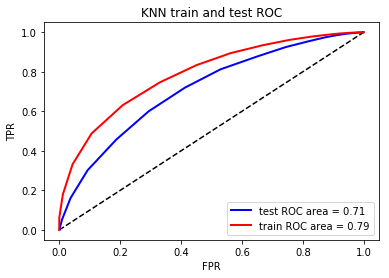

In [20]:
k = 39 #neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs=6)
knn.fit(tfidf_w2v_x_train,tfidf_w2v_y_train)
test_pred_prob = knn.predict_proba(tfidf_w2v_x_test)[:,1]
# test AUC
test_fpr, test_tpr, _ = roc_curve(tfidf_w2v_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [21]:
test_pred = knn.predict(tfidf_w2v_x_test)
conf_matrix = confusion_matrix(tfidf_w2v_y_test, test_pred)
report = classification_report(tfidf_w2v_y_test, test_pred)
print("confusion matrix\n",conf_matrix)
print("report\n",report)
 

confusion matrix
 [[    0  2678]
 [    1 17321]]
report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2678
           1       0.87      1.00      0.93     17322

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.43      0.50      0.46     20000
weighted avg       0.75      0.87      0.80     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

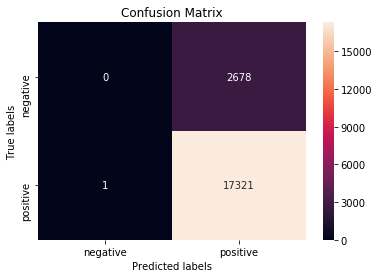

In [14]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### AUC graph, ROC and confusion matrix for original data

K with maximum score on validation data :  39


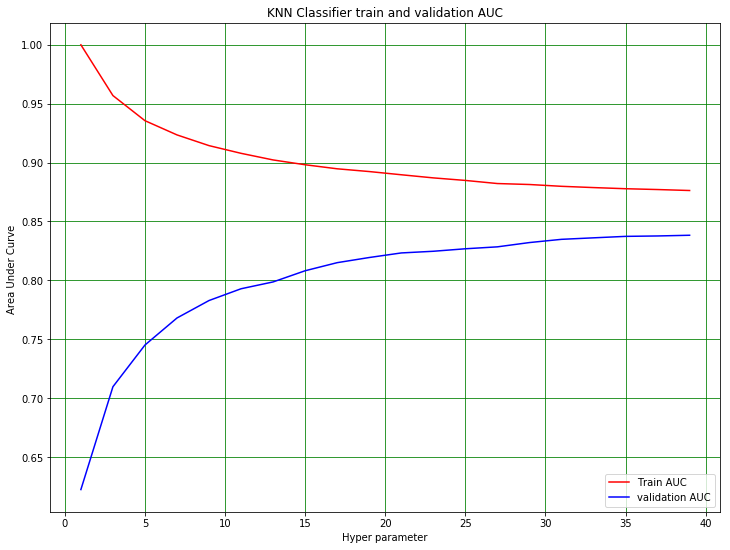

In [19]:
# finding best K with cross validation
print("K with maximum score on validation data : ",neighbors[val_auc.index(max(val_auc))])
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="lower right")
plt.show() 

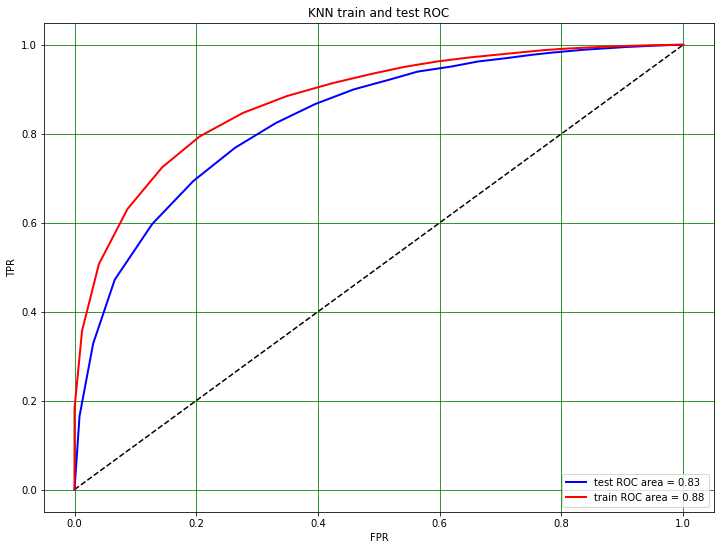

In [20]:
k = 39 #neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs=6)
knn.fit(tfidf_w2v_x_train,tfidf_w2v_y_train)
test_pred_prob = knn.predict_proba(tfidf_w2v_x_test)[:,1]
# test AUC
test_fpr, test_tpr, _ = roc_curve(tfidf_w2v_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [21]:
test_pred = knn.predict(tfidf_w2v_x_test)
conf_matrix = confusion_matrix(tfidf_w2v_y_test, test_pred)
report = classification_report(tfidf_w2v_y_test, test_pred)
print("confusion matrix\n",conf_matrix)
print("report\n",report)
 

confusion matrix
 [[  303  2375]
 [  116 17206]]
report
               precision    recall  f1-score   support

           0       0.72      0.11      0.20      2678
           1       0.88      0.99      0.93     17322

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.80      0.55      0.56     20000
weighted avg       0.86      0.88      0.83     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

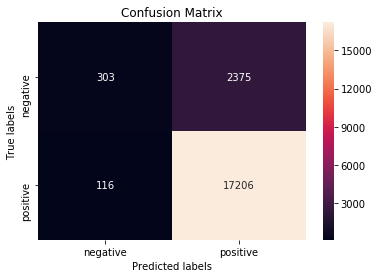

In [15]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

In [ ]:
with open("amazon-fine-food-reviews/X_train.pkl","rb") as file:
  X_train = pickle.load(file)
  
with open("amazon-fine-food-reviews/X_test.pkl","rb") as file:
  X_test = pickle.load(file)

with open("amazon-fine-food-reviews/X_val.pkl","rb") as file:
  X_val = pickle.load(file)

In [ ]:
cv = CountVectorizer(min_df=10, max_features=100)
BOW_x_train = cv.fit_transform(X_train.values).toarray()
print("Shape of train BOW matrix : ",BOW_x_train.shape)
BOW_x_val = cv.transform(X_val.values).toarray()
print("Shape of test BOW matrix : ",BOW_x_val.shape)
BOW_x_test = cv.transform(X_test.values).toarray()
print("Shape of test BOW matrix : ",BOW_x_test.shape)

In [ ]:
# read BOW vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  BOW_y_train = pickle.load(file)
  BOW_y_train = [1 if x=='positive' else 0 for x in BOW_y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  BOW_y_test = pickle.load(file)
  BOW_y_test = [1 if x=='positive' else 0 for x in BOW_y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  BOW_y_val = pickle.load(file)  
  BOW_y_val = [1 if x=='positive' else 0 for x in BOW_y_val]

In [8]:
# creating odd list of K for KNN
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=6)
    knn.fit(BOW_x_train,BOW_y_train)
    
    #predict probabilities for train and validation    
    train_pred_prob = knn.predict_proba(BOW_x_train)[:,1]
    val_pred_prob = knn.predict_proba(BOW_x_val)[:,1]
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(BOW_y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(BOW_y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))   

100%|██████████| 15/15 [1:27:28<00:00, 364.29s/it]


K with maximum score on validation data :  27


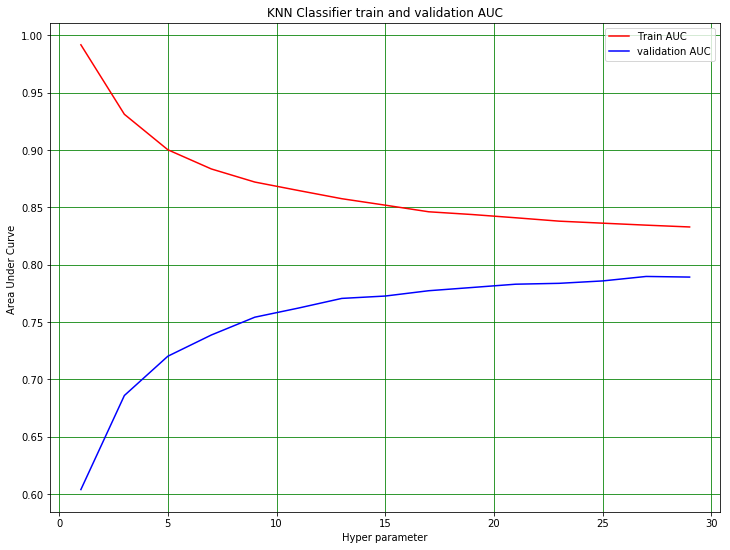

In [9]:
# finding best K with cross validation
print("K with maximum score on validation data : ",neighbors[val_auc.index(max(val_auc))])
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="upper right")
plt.show()

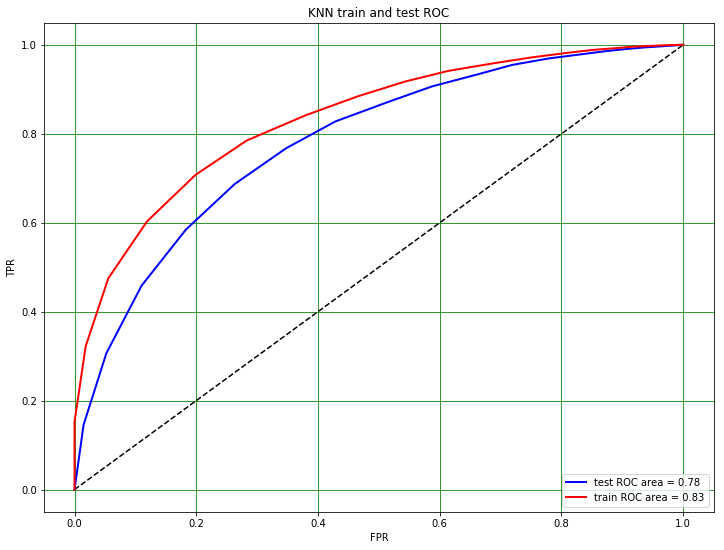

In [48]:
k = neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k,algorithm='kd_tree', n_jobs=6)
knn.fit(BOW_x_train,BOW_y_train)
test_pred_prob = knn.predict_proba(BOW_x_test)[:,1]

# test AUC
test_fpr, test_tpr, _ = roc_curve(BOW_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)
plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [11]:
test_pred = knn.predict(BOW_x_test)
conf_matrix = confusion_matrix(BOW_y_test, test_pred)
report = classification_report(BOW_y_test, test_pred)
print("confusion matrix\n",conf_matrix)
print("report\n",report)
 

confusion matrix
 [[  347  2331]
 [  254 17068]]
report
               precision    recall  f1-score   support

           0       0.58      0.13      0.21      2678
           1       0.88      0.99      0.93     17322

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.73      0.56      0.57     20000
weighted avg       0.84      0.87      0.83     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

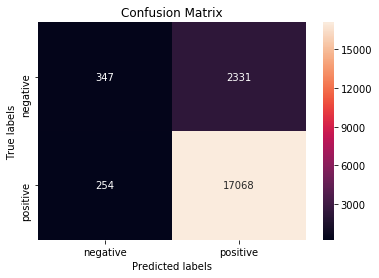

In [16]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

In [40]:
with open("amazon-fine-food-reviews/X_train.pkl","rb") as file:
  X_train = pickle.load(file)
  
with open("amazon-fine-food-reviews/X_test.pkl","rb") as file:
  X_test = pickle.load(file)

with open("amazon-fine-food-reviews/X_val.pkl","rb") as file:
  X_val = pickle.load(file)

In [41]:
tf_idf_model = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=100)
TFIDF_x_train = tf_idf_model.fit_transform(X_train.values).toarray()
TFIDF_x_val = tf_idf_model.transform(X_val.values).toarray()
TFIDF_x_test = tf_idf_model.transform(X_test.values).toarray()

In [43]:
# read BOW vectors stored in pickle file and related lables
with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  TFIDF_y_train = pickle.load(file)
  TFIDF_y_train = [1 if x=='positive' else 0 for x in TFIDF_y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  TFIDF_y_test = pickle.load(file)
  TFIDF_y_test = [1 if x=='positive' else 0 for x in TFIDF_y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  TFIDF_y_val = pickle.load(file)  
  TFIDF_y_val = [1 if x=='positive' else 0 for x in TFIDF_y_val]

In [17]:
# creating odd list of K for KNN
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=6)
    knn.fit(TFIDF_x_train,TFIDF_y_train)
    
    #predict probabilities for train and validation
    train_pred_prob = knn.predict_proba(TFIDF_x_train)[:,1]
    val_pred_prob = knn.predict_proba(TFIDF_x_val)[:,1]
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(TFIDF_y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(TFIDF_y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))   

100%|██████████| 15/15 [1:37:36<00:00, 400.93s/it]


K with maximum score on validation data :  29


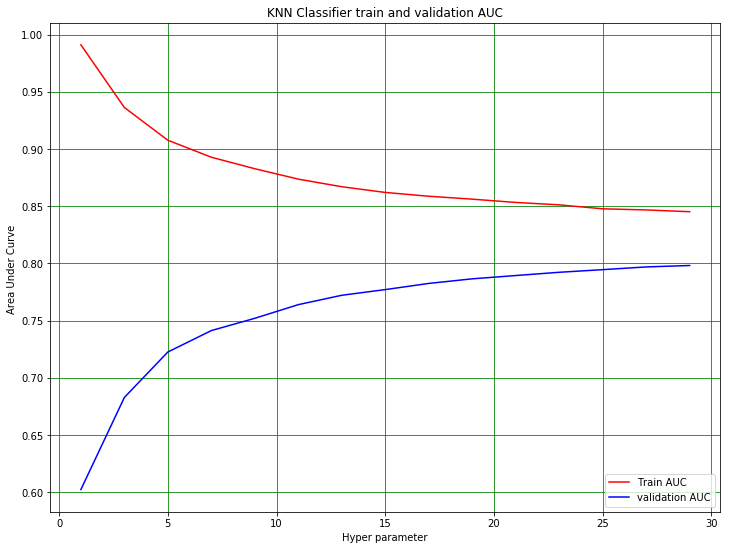

In [18]:
# finding best K with cross validation
print("K with maximum score on validation data : ",neighbors[val_auc.index(max(val_auc))])
plt.figure(figsize=(12, 9))
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="lower right")
plt.grid(True,color='g')
plt.show() 

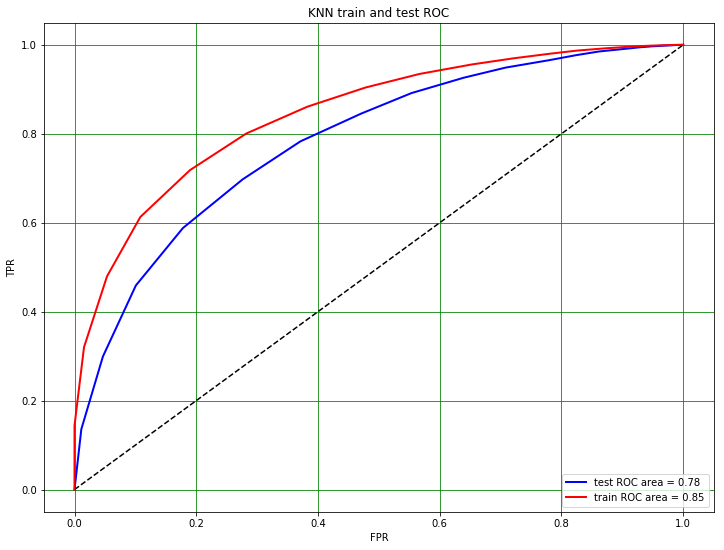

In [47]:
k = neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k,algorithm='kd_tree', n_jobs=6)
knn.fit(TFIDF_x_train,TFIDF_y_train)
test_pred_prob = knn.predict_proba(TFIDF_x_test)[:,1]

# test AUC
test_fpr, test_tpr, _ = roc_curve(TFIDF_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)

plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [20]:
test_pred = knn.predict(TFIDF_x_test)
conf_matrix = confusion_matrix(TFIDF_y_test, test_pred)
report = classification_report(TFIDF_y_test, test_pred)
print("confusion matrix\n",conf_matrix)
print("report\n",report)
 

confusion matrix
 [[  191  2487]
 [   97 17225]]
report
               precision    recall  f1-score   support

           0       0.66      0.07      0.13      2678
           1       0.87      0.99      0.93     17322

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.77      0.53      0.53     20000
weighted avg       0.85      0.87      0.82     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

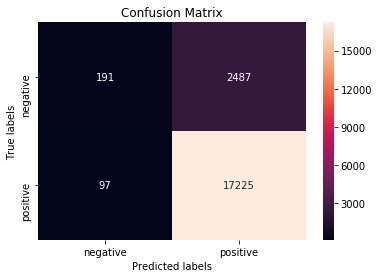

In [17]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [38]:
# read BOW vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_train.pkl","rb") as file:
  avg_w2v_x_train = pickle.load(file)

with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_val.pkl","rb") as file:
  avg_w2v_x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/avg_w2v/avg_w2v_x_test.pkl","rb") as file:
  avg_w2v_x_test = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  avg_w2v_y_train = pickle.load(file)
  avg_w2v_y_train = [1 if x=='positive' else 0 for x in avg_w2v_y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  avg_w2v_y_test = pickle.load(file)
  avg_w2v_y_test = [1 if x=='positive' else 0 for x in avg_w2v_y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  avg_w2v_y_val = pickle.load(file)  
  avg_w2v_y_val = [1 if x=='positive' else 0 for x in avg_w2v_y_val]

In [23]:
# creating odd list of K for KNN
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=6)
    knn.fit(avg_w2v_x_train,avg_w2v_y_train)
    
    #predict probabilities for train and validation
    train_pred_prob = knn.predict_proba(avg_w2v_x_train)[:,1]
    val_pred_prob = knn.predict_proba(avg_w2v_x_val)[:,1]
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(avg_w2v_y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(avg_w2v_y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))   

100%|██████████| 15/15 [1:03:13<00:00, 270.60s/it]


K with maximum score on validation data :  29


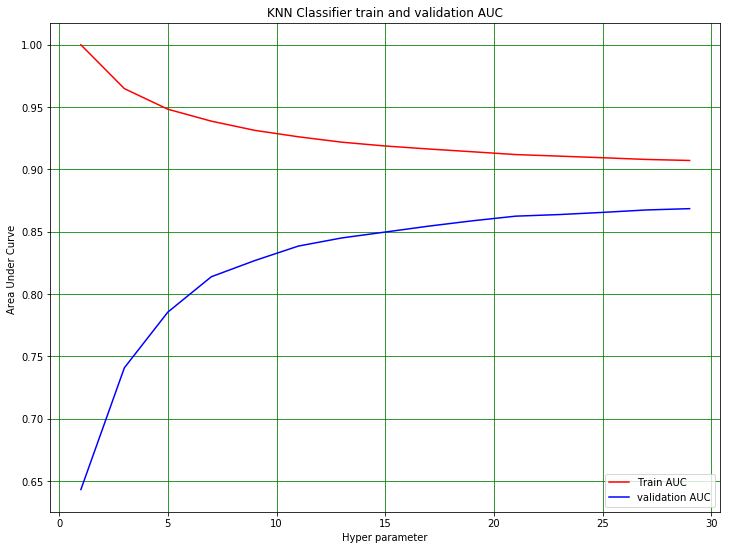

In [24]:
# finding best K with cross validation
print("K with maximum score on validation data : ",neighbors[val_auc.index(max(val_auc))])
plt.figure(figsize=(12,9))
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="lower right")
plt.grid(True,color='g')
plt.show() 

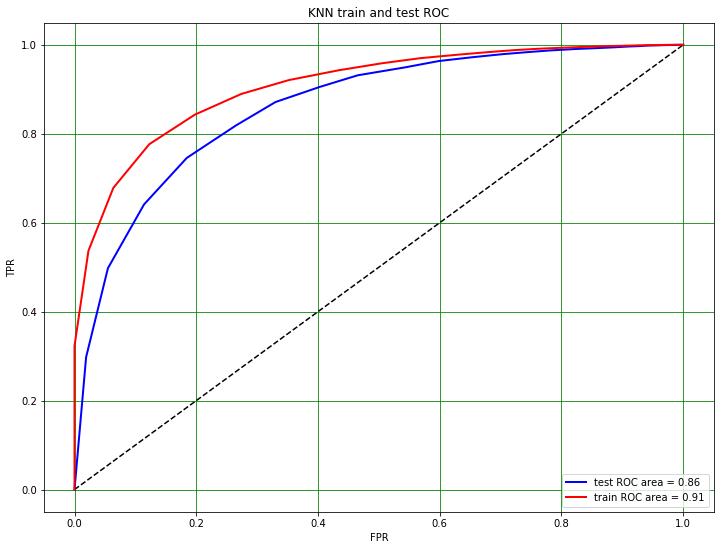

In [45]:
k = neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k,algorithm='kd_tree', n_jobs=6)
knn.fit(avg_w2v_x_train,avg_w2v_y_train)
test_pred_prob = knn.predict_proba(avg_w2v_x_test)[:,1]

# test AUC
test_fpr, test_tpr, _ = roc_curve(avg_w2v_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)

plt.figure(figsize=(12, 9))
plt.grid(True,color='g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.show()

In [26]:
test_pred = knn.predict(avg_w2v_x_test)
conf_matrix = confusion_matrix(avg_w2v_y_test, test_pred)
report = classification_report(avg_w2v_y_test, test_pred)
print("confusion matrix\n",conf_matrix)
print("report\n",report)
 

confusion matrix
 [[  476  2202]
 [  165 17157]]
report
               precision    recall  f1-score   support

           0       0.74      0.18      0.29      2678
           1       0.89      0.99      0.94     17322

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.81      0.58      0.61     20000
weighted avg       0.87      0.88      0.85     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

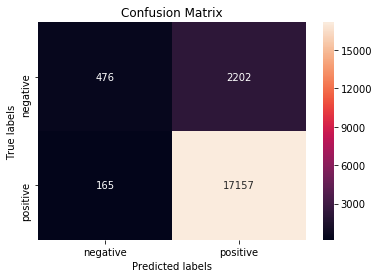

In [18]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [35]:
# read BOW vectors stored in pickle file and related lables
import pickle
with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_train.pkl","rb") as file:
  tfidf_w2v_x_train = pickle.load(file)

with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_val.pkl","rb") as file:
  tfidf_w2v_x_val = pickle.load(file)
  
with open("amazon-fine-food-reviews/tfidf_w2v/tfidf_w2v_x_test.pkl","rb") as file:
  tfidf_w2v_x_test = pickle.load(file)

with open("amazon-fine-food-reviews/y_train.pkl","rb") as file:
  tfidf_w2v_y_train = pickle.load(file)
  tfidf_w2v_y_train = [1 if x=='positive' else 0 for x in tfidf_w2v_y_train]
with open("amazon-fine-food-reviews/y_test.pkl","rb") as file:
  tfidf_w2v_y_test = pickle.load(file)
  tfidf_w2v_y_test = [1 if x=='positive' else 0 for x in tfidf_w2v_y_test]
with open("amazon-fine-food-reviews/y_val.pkl","rb") as file:
  tfidf_w2v_y_val = pickle.load(file)  
  tfidf_w2v_y_val = [1 if x=='positive' else 0 for x in tfidf_w2v_y_val]

In [30]:
# creating odd list of K for KNN
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
train_fpr = dict()
train_tpr = dict()
val_fpr = dict()
val_tpr = dict()
train_auc = []
val_auc = []
# perform  cross validation
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=6)
    knn.fit(tfidf_w2v_x_train,tfidf_w2v_y_train)
    
    #predict probabilities for train and validation
    train_pred_prob = knn.predict_proba(tfidf_w2v_x_train)[:,1]
    val_pred_prob = knn.predict_proba(tfidf_w2v_x_val)[:,1]
    # train AUC
    train_fpr[k], train_tpr[k], _ = roc_curve(tfidf_w2v_y_train, train_pred_prob,pos_label = 1)
    train_auc.append(auc(train_fpr[k], train_tpr[k]))
    # validation AUC
    val_fpr[k], val_tpr[k], _ = roc_curve(tfidf_w2v_y_val, val_pred_prob,pos_label = 1)
    val_auc.append(auc(val_fpr[k], val_tpr[k]))   

100%|██████████| 15/15 [53:55<00:00, 236.09s/it]


K with maximum score on validation data :  29


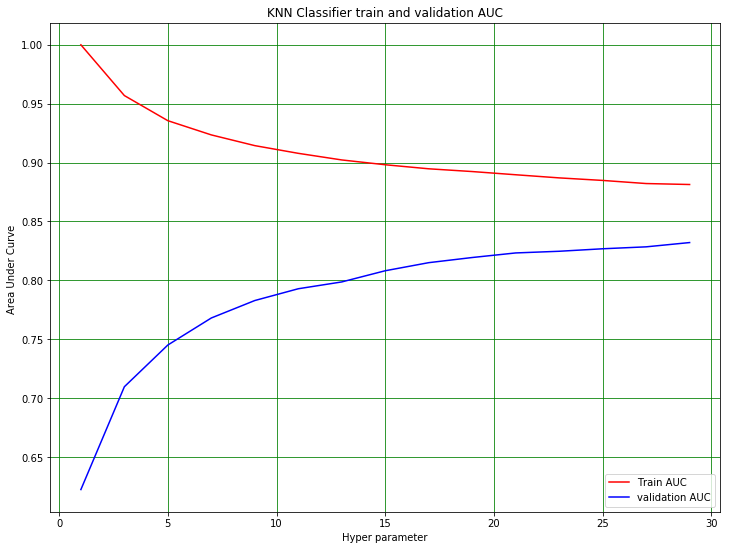

In [31]:
# finding best K with cross validation
print("K with maximum score on validation data : ",neighbors[val_auc.index(max(val_auc))])
plt.figure(figsize=(12,9))
plt.xlabel('Hyper parameter')
plt.ylabel('Area Under Curve ')
plt.title('KNN Classifier train and validation AUC')
plt.plot(neighbors,train_auc, color='red', label='Train AUC')
plt.plot(neighbors,val_auc, color='blue', label='validation AUC')
plt.legend(loc="lower right")
plt.grid(True,color='g')
plt.show() 

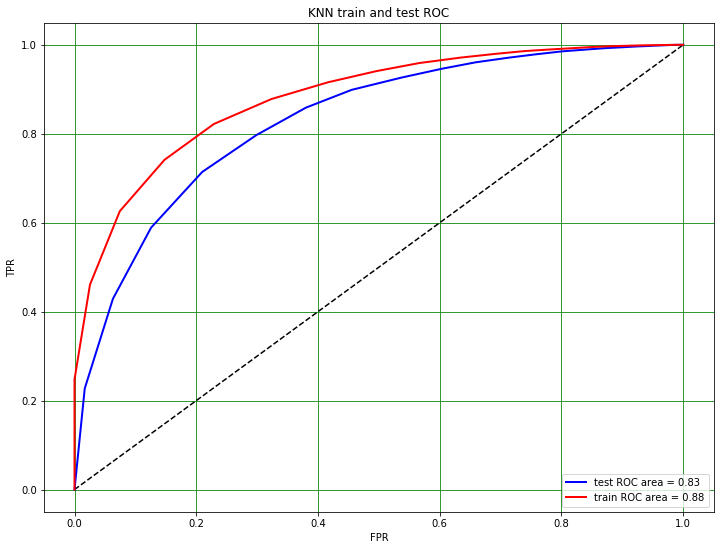

In [37]:
k = neighbors[val_auc.index(max(val_auc))]
knn = KNeighborsClassifier(n_neighbors = k,algorithm='kd_tree', n_jobs=6)
knn.fit(tfidf_w2v_x_train,tfidf_w2v_y_train)
test_pred_prob = knn.predict_proba(tfidf_w2v_x_test)[:,1]

# test AUC
test_fpr, test_tpr, _ = roc_curve(tfidf_w2v_y_test, test_pred_prob,pos_label = 1)
test_auc = auc(test_fpr, test_tpr)

plt.figure(figsize=(12,9))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('KNN train and test ROC')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='test ROC area = %0.2f' % test_auc)
plt.plot(train_fpr[k], train_tpr[k], color='red', lw=2, label='train ROC area = %0.2f' % train_auc[neighbors.index(k)])
plt.legend(loc="lower right")
plt.grid(True,color='g')
plt.show()

In [33]:
test_pred = knn.predict(tfidf_w2v_x_test)
conf_matrix = confusion_matrix(tfidf_w2v_y_test, test_pred)
report = classification_report(tfidf_w2v_y_test, test_pred)
print("confusion matrix\n",conf_matrix)
print("report\n",report)
 

confusion matrix
 [[  342  2336]
 [  130 17192]]
report
               precision    recall  f1-score   support

           0       0.72      0.13      0.22      2678
           1       0.88      0.99      0.93     17322

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.80      0.56      0.58     20000
weighted avg       0.86      0.88      0.84     20000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

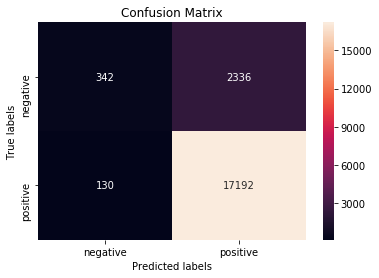

In [20]:
heat_map = plt.subplot()
sn.heatmap(conf_matrix, annot=True, ax = heat_map, fmt='g') 

heat_map.set_ylabel('True labels')
heat_map.set_xlabel('Predicted labels')
heat_map.set_title('Confusion Matrix') 
heat_map.xaxis.set_ticklabels(['negative', 'positive']) 
heat_map.yaxis.set_ticklabels(['negative', 'positive'])

# [6] Conclusions

### With featurization

In [1]:
from prettytable import PrettyTable

In [53]:
pt = PrettyTable()
pt.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

pt.add_row(["BOW", "Brute", 39, 0.71])
pt.add_row(["TFIDF","Brute", 39, 0.62])
pt.add_row(["AVG W2V","Brute", 39, 0.73])
pt.add_row(["TFIDF W2V","Brute", 39, 0.71])
print(pt)

+------------+-------+-----------------+------+
| Vectorizer | Model | Hyper Parameter | AUC  |
+------------+-------+-----------------+------+
|    BOW     | Brute |        39       | 0.71 |
|   TFIDF    | Brute |        39       | 0.62 |
|  AVG W2V   | Brute |        39       | 0.73 |
| TFIDF W2V  | Brute |        39       | 0.71 |
+------------+-------+-----------------+------+


### without featurization 

In [2]:
pt = PrettyTable()
pt.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

pt.add_row(["BOW", "Brute", 39, 0.79])
pt.add_row(["TFIDF","Brute", 39, 0.85])
pt.add_row(["AVG W2V","Brute", 39, 0.87])
pt.add_row(["TFIDF W2V","Brute", 39, 0.83])
print(pt)

+------------+-------+-----------------+------+
| Vectorizer | Model | Hyper Parameter | AUC  |
+------------+-------+-----------------+------+
|    BOW     | Brute |        39       | 0.79 |
|   TFIDF    | Brute |        39       | 0.85 |
|  AVG W2V   | Brute |        39       | 0.87 |
| TFIDF W2V  | Brute |        39       | 0.83 |
+------------+-------+-----------------+------+


In [52]:
pt = PrettyTable()
pt.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

pt.add_row(["BOW","Kd-tree", 27, 0.78])
pt.add_row(["TFIDF", "Kd-tree", 29, 0.78])
pt.add_row(["AVG W2V", "Kd-tree", 29, 0.86])
pt.add_row(["TFIDF W2V", "Kd-tree", 29, 0.83])
print(pt)

+------------+---------+-----------------+------+
| Vectorizer |  Model  | Hyper Parameter | AUC  |
+------------+---------+-----------------+------+
|    BOW     | Kd-tree |        27       | 0.78 |
|   TFIDF    | Kd-tree |        29       | 0.78 |
|  AVG W2V   | Kd-tree |        29       | 0.86 |
| TFIDF W2V  | Kd-tree |        29       | 0.83 |
+------------+---------+-----------------+------+


Observations: 
* Added new features like number of words, nouns, adjective, verb, adverb in reviews. This led to biased models where models classified only 0 to 5 data points as negative out of 2336 negative data points and all other points as positive.
* While preprocessing doing lemmatization with POS tag instead of stemming and removing "not" from stop words helped in increasing the AUC.